In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)

numpy: 1.23.2
astropy: 5.1


In [3]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

from copy import copy

In [4]:
from astropy.io import fits

To open the fits file we use `fits.open()` and just specify the filename as an argument:

In [5]:
fits_file = fits.open('../1_read_data/data_test/run_05029747_DL3.fits')

We can retrieve some basic information on the  header data unit (HDU) by calling `.info()`:

In [6]:
fits_file.info()

Filename: ../1_read_data/data_test/run_05029747_DL3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  EVENTS        1 BinTableHDU     59   6310R x 5C   [1K, 1D, 1E, 1E, 1E]   
  2  GTI           1 BinTableHDU     24   1R x 2C   [1D, 1D]   
  3  EFFECTIVE AREA    1 BinTableHDU     37   1R x 5C   [21E, 21E, 2E, 2E, 42E]   
  4  ENERGY DISPERSION    1 BinTableHDU     37   1R x 7C   [20E, 20E, 80E, 80E, 2E, 2E, 3200E]   


### Events

In [7]:
events = fits_file['EVENTS']

In [8]:
events.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   28 / width of table in bytes                        
NAXIS2  =                 6310 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'EVENT_ID'           / label for field   1                            
TFORM1  = '1K      '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'TIME    '           / label for field   2                            
TFORM2  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT2  = 's       '        

### PLOT SOURCE, POINTING and ON and OFF REGIONS

In [9]:
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs import WCS

In [11]:
pointing_pos =  SkyCoord( events.header.get('RA_PNT') *u.deg,   events.header.get('DEC_PNT') *u.deg )
source_pos   =  SkyCoord.from_name(events.header.get('OBJECT'))

In [12]:
offset = source_pos.separation(pointing_pos)
offset.to( u.deg).value

0.39727511625478695

In [13]:
# angle position of the source relative to the pointing
source_angle = pointing_pos.position_angle(source_pos).to(u.degree)
off1_angle   = source_angle + 90*u.deg
off2_angle   = off1_angle   + 90*u.deg
off3_angle   = off2_angle   + 90*u.deg

#off4_angle   = off3_angle   + 43*u.deg
#off5_angle   = off4_angle   + 43*u.deg
#off6_angle   = off5_angle   + 43*u.deg
#off7_angle   = off6_angle   + 43*u.deg

In [14]:
off1_pos = pointing_pos.directional_offset_by(position_angle=off1_angle, separation=offset)  
off2_pos = pointing_pos.directional_offset_by(position_angle=off2_angle, separation=offset)  
off3_pos = pointing_pos.directional_offset_by(position_angle=off3_angle, separation=offset) 

#off4_pos = pointing_pos.directional_offset_by(position_angle=off4_angle, separation=offset)  
#off5_pos = pointing_pos.directional_offset_by(position_angle=off5_angle, separation=offset)  
#off6_pos = pointing_pos.directional_offset_by(position_angle=off6_angle, separation=offset)  
#off7_pos = pointing_pos.directional_offset_by(position_angle=off7_angle, separation=offset)  

In [15]:
radius = offset/np.sqrt(2)
radius /=2

radius = 0.1414213*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

#off4 = SphericalCircle( (off4_pos.ra, off4_pos.dec),
#                    radius,   edgecolor='black', facecolor='none')
#off5 = SphericalCircle( (off5_pos.ra, off5_pos.dec),
#                    radius,   edgecolor='black', facecolor='none')
#off6 = SphericalCircle( (off6_pos.ra, off6_pos.dec),
#                    radius,   edgecolor='black', facecolor='none')
#off7 = SphericalCircle( (off7_pos.ra, off7_pos.dec),
#                    radius,   edgecolor='black', facecolor='none')

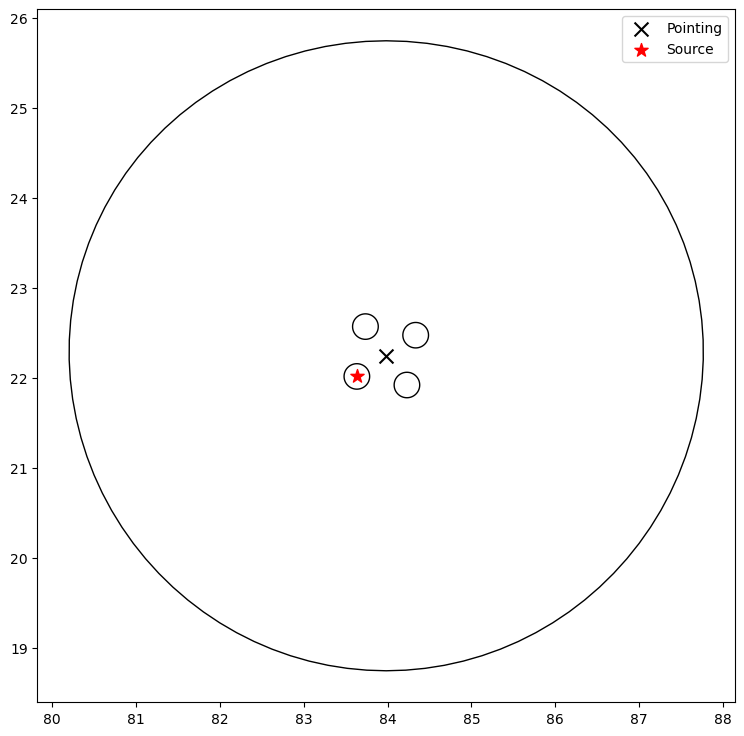

In [16]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = plt.subplot()


field_of_view = SphericalCircle( (pointing_pos.ra, pointing_pos.dec),
                    3.5 * u.deg,   edgecolor='black', facecolor='none')


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

ax.add_patch(field_of_view)

ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)

#ax.add_patch(off4)
#ax.add_patch(off5)
#ax.add_patch(off6)
#ax.add_patch(off7)

ax.legend();

### PLOT AZIMUTH AND ALTITUDE DURING THE OBSERVATION

In [17]:
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time

In [18]:
ROM = EarthLocation( lat=events.header.get('GEOLAT')* u.deg, 
              lon=events.header.get('GEOLON') * u.deg, 
              height= events.header.get('ALTITUDE')*u.m)
print(ROM)

(5326845.71658856, -1719569.6479979, 3051841.96403305) m


In [19]:
start_time = Time( events.header.get('DATE-OBS') +'T'+events.header.get('TIME-OBS')) 
end_time   = Time( events.header.get('DATE-END') +'T'+events.header.get('TIME-END')) 

In [20]:
dt = ( end_time - start_time ) /100
times        = []
source_altaz = []
for i in range(100):
    time        = start_time + dt*i
    altaz        = AltAz(obstime=time, location=ROM)
    i_source_altaz = source_pos.transform_to(altaz)
    times.append( time )
    source_altaz.append( i_source_altaz )
    

In [21]:
all_alt = [  i.alt.value for i in source_altaz ]
all_az  = [  i.az.value  for i in source_altaz ]

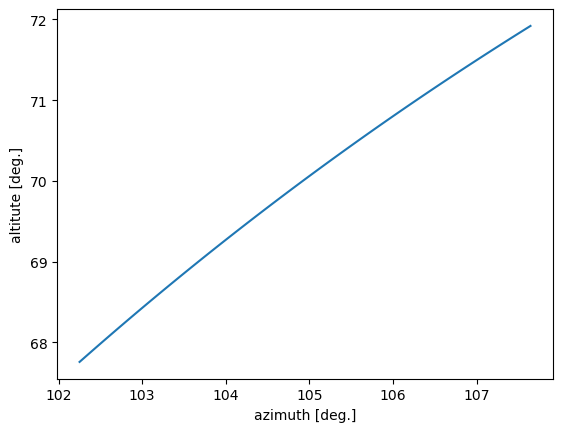

In [22]:
plt.plot(  all_az, all_alt)
plt.xlabel( "azimuth [deg.]")
plt.ylabel( "altitute [deg.]");

## GET EVENTS

In [23]:
events_table = Table( events.data )
events_table

EVENT_ID,TIME,RA,DEC,ENERGY
int64,float64,float32,float32,float32
42,333778849.5267153,444.21463,23.44914,0.08397394
67,333778849.61315054,443.5247,22.725792,0.10596932
80,333778849.6690142,443.76956,22.451006,0.19733498
116,333778849.7778549,443.71518,21.985115,1.0020943
179,333778849.9826064,443.64136,22.041315,0.10316629
198,333778850.0339344,444.84238,22.175398,0.118843034
251,333778850.20117164,442.21805,21.617695,0.2293238
...,...,...,...,...
570,333780036.17792755,443.99866,22.431725,0.14909887


In [24]:
radius = offset/np.sqrt(2)
radius /=2

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

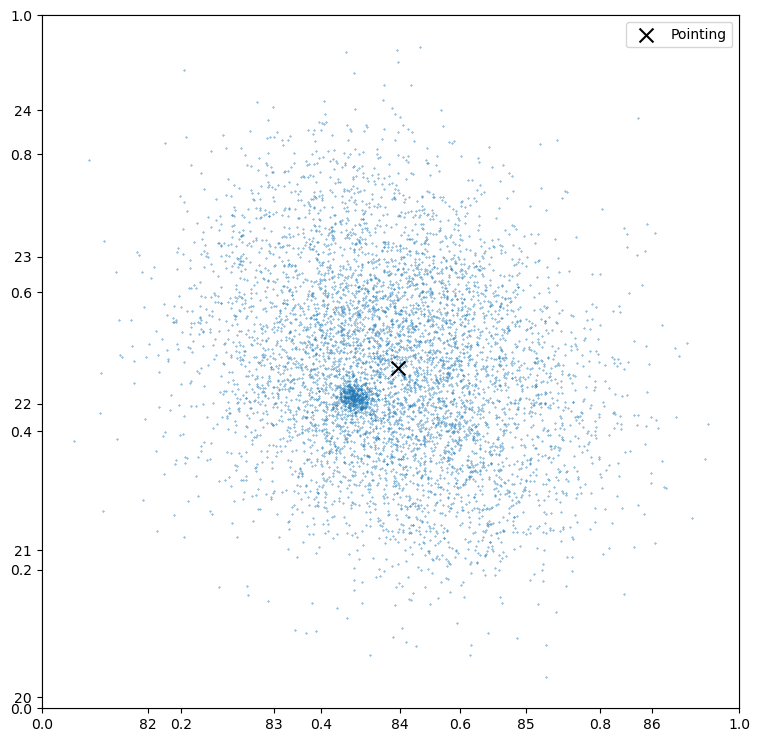

In [25]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot()

ra =   -360*u.deg + events_table['RA'] * u.deg  

dec = events_table['DEC']*u.deg

ax.scatter(ra, dec, s=0.1)


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
#ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 


#ax.add_patch(on)
#ax.add_patch(off1)
#ax.add_patch(off2)
#ax.add_patch(off3)

ax.legend();

In [26]:
ra = events_table['RA'] 
dec = events_table['DEC']

radius = 0.1414213*u.deg 

cond_on = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_on.append( source_pos.separation(position_event) <= radius )
    
cond_off1 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off1.append( off1_pos.separation(position_event) <= radius )
    
cond_off2 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off2.append( off2_pos.separation(position_event) <= radius )
    

cond_off3 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off3.append( off3_pos.separation(position_event) <= radius )
    
    
######

#cond_off4 = []
#for i_ra,i_dec in zip(ra,dec):
#    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')#

#    cond_off4.append( off4_pos.separation(position_event) <= radius )
    
#cond_off5 = []
#for i_ra,i_dec in zip(ra,dec):
#    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

#    cond_off5.append( off5_pos.separation(position_event) <= radius )
    
#cond_off6 = []
#for i_ra,i_dec in zip(ra,dec):
#    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

#    cond_off6.append( off6_pos.separation(position_event) <= radius )
    
#cond_off7 = []
#for i_ra,i_dec in zip(ra,dec):
#    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

#    cond_off7.append( off7_pos.separation(position_event) <= radius )

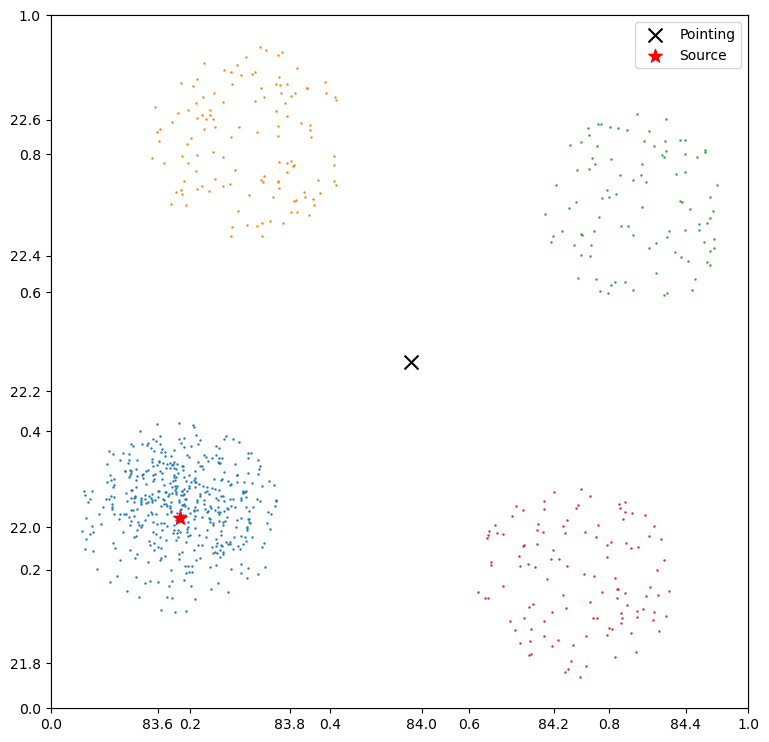

In [27]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot()

ra = events_table[cond_on]['RA'] - 360
dec = events_table[cond_on]['DEC']
ax.scatter(ra, dec, s=0.5)

ra = events_table[cond_off1]['RA'] - 360
dec = events_table[cond_off1]['DEC']
ax.scatter(ra, dec, s=0.5)

ra = events_table[cond_off2]['RA'] - 360
dec = events_table[cond_off2]['DEC']
ax.scatter(ra, dec, s=0.5)

ra = events_table[cond_off3]['RA'] - 360
dec = events_table[cond_off3]['DEC']
ax.scatter(ra, dec, s=0.5)



ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 



ax.legend();

### Effective Area

In [34]:
effective_area = fits_file['EFFECTIVE AREA']

In [35]:
effective_area.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  352 / width of table in bytes                        
NAXIS2  =                    1 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'ENERG_LO'           / label for field   1                            
TFORM1  = '21E     '           / data format of field: 4-byte REAL              
TUNIT1  = 'TeV     '           / physical unit of field                         
TTYPE2  = 'ENERG_HI'           / label for field   2                            
TFORM2  = '21E     '        

In [36]:
effective_area.header.get('RAD_MAX')

0.1414213

In [37]:
effective_area.header.get('GADF')

In [38]:
effective_area = Table( effective_area.data)

In [39]:
theta_low  = np.array( effective_area['THETA_LO'] )[0]
theta_high = np.array( effective_area['THETA_HI'] )[0]

en_low     = np.array( effective_area['ENERG_LO'] )[0]
en_high    = np.array( effective_area['ENERG_HI'] )[0]
en_center = np.sqrt( en_low * en_high )
delta_E  = (en_high - en_low)

eff_area   = np.array( effective_area['EFFAREA'] )[0][0]



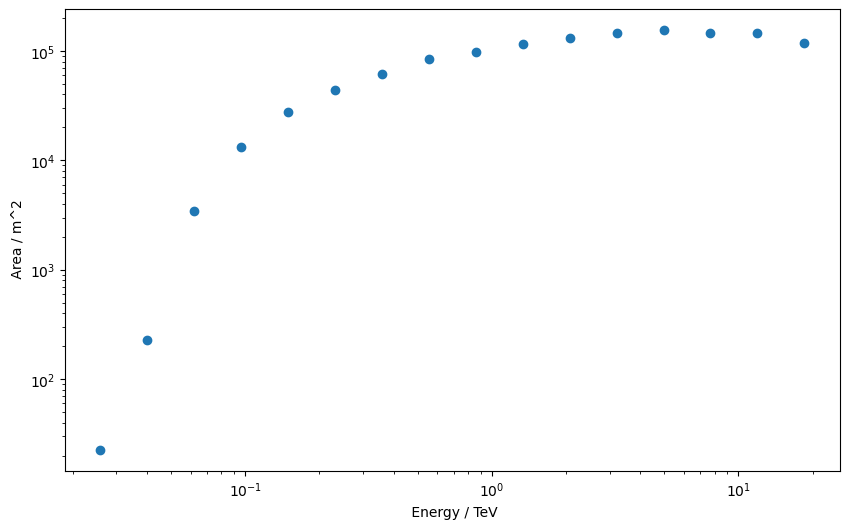

In [122]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.scatter(en_center,  eff_area)


ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Area / m^2')
ax.set_xscale('log')
ax.set_yscale('log')

In [41]:
# REMOVE BIN WITH EFF AREA = 0
cond = eff_area >0
en_center = en_center[cond]
en_low    = en_low[cond]
en_high   = en_high[cond]
delta_E    = delta_E[cond]

eff_area  = eff_area[cond]

### COMPUTE EXCESS

In [42]:
excess = [] 
err_excess = []

noff_list = []
non_list  = []

for i_en_low, i_en_high in zip( en_low, en_high):
    cond_low  = events_table['ENERGY'] >= i_en_low
    cond_high = events_table['ENERGY']  < i_en_high
    cond_en   = cond_low* cond_high
    
    non    = np.sum( cond_en*cond_on)
    
    noff   = np.sum( cond_en*cond_off1) +\
             np.sum( cond_en*cond_off2) +\
             np.sum( cond_en*cond_off3) 
            # np.sum( cond_en*cond_off4) +\
            # np.sum( cond_en*cond_off5) +\
            # np.sum( cond_en*cond_off6) +\
            # np.sum( cond_en*cond_off7) 
    
    noff_list.append(noff)
    non_list.append(non)
    
    excess.append( non - noff/3 )
    err_excess.append( np.sqrt( non + (1/3)**2*noff) )
    
excess     = np.array(excess)
err_excess = np.array(err_excess)

non_list   = np.array(non_list)
noff_list   = np.array(noff_list)

In [44]:
np.sum( non_list )

484

In [45]:
np.sum( noff_list)

339

In [46]:
def log_likelihood(s, Non, Noff, a):
    # we firts get the b that maximez the likelihood
    N     = Non + Noff - (1+1/a) *s
    b     = (N + np.sqrt( N**2  + 4* (1+1/a) *s*Noff ))/(2+2*a)
    
    # Now we can compute the tree terms of the likelihood
    if Non == 0:
        term1 = np.zeros_like(s)
    else:
        term1 = Non*np.log( Non/(s + a*b)  )

    if Noff == 0:
        term2 = np.zeros_like(s)
    else:
        term2 = Noff*np.log( Noff/b  )
 
    term3 = s + (1+a)*b - Non - Noff
    
    return 2*(term1 + term2 + term3)

In [48]:
np.sqrt( log_likelihood(s=0, Non=484, Noff=339, a=1/3) )

20.536351742155894

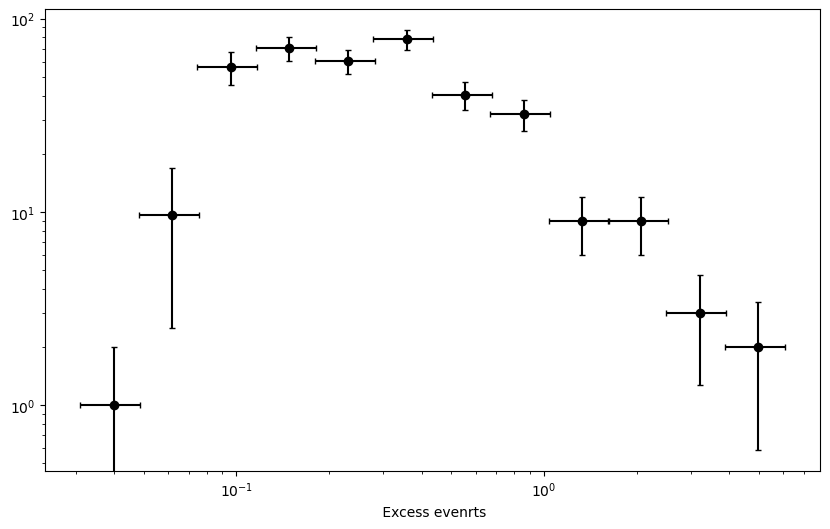

In [331]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, y=excess, yerr=err_excess , xerr = delta_E/2 , c='black', capsize=2, fmt='o')

ax.set_xlabel( ' Energy / TeV')
ax.set_xlabel( ' Excess evenrts')
ax.set_xscale('log')
ax.set_yscale('log')

In [332]:
# REMOVE BIN WITH NEGATIVE OR ZERO EXCESS
cond = excess >0
en_center = en_center[cond]
en_low    = en_low[cond]
en_high   = en_high[cond]
delta_E    = delta_E[cond]

eff_area  = eff_area[cond]

excess     = excess[cond]
err_excess = err_excess[cond]

noff_list = noff_list[cond]
non_list  = non_list[cond]

### COMPUTE FLUX

In [135]:
exposure_time = events.header.get('LIVETIME') * u.second 
exposure_time.to( u.minute)

<Quantity 19.67830828 min>

In [136]:
def log_parababola( e, f0, E0, a, b):
    return f0* (e/E0) **( - a + b* np.log( e/E0))

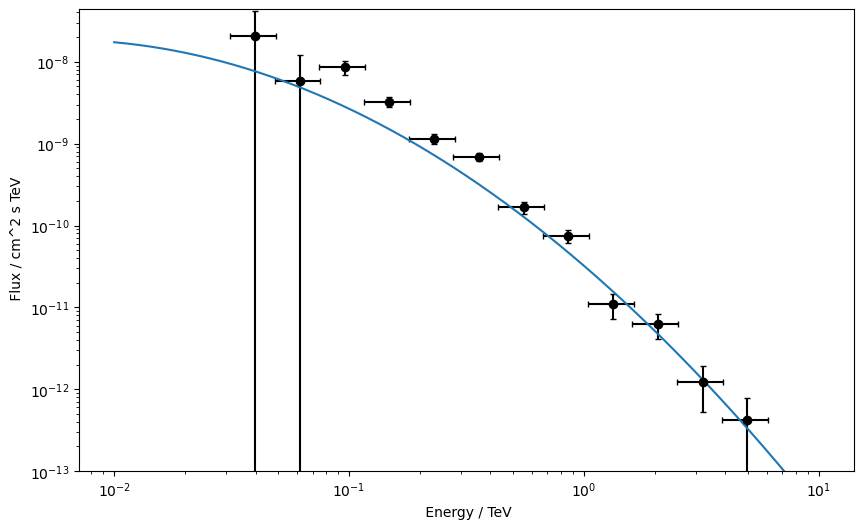

In [137]:
flux = excess/( eff_area * u.m**2)/ exposure_time/ ( delta_E *u.TeV)

flux_err = err_excess/( eff_area * u.m**2)/ exposure_time/ ( delta_E *u.TeV)




fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, 
            y=flux.to( 1/(u.TeV * u.cm**2 * u.s) ).value, 
            yerr = flux_err.to( 1/(u.TeV * u.cm**2 * u.s) ).value , 
            xerr = delta_E/2 , c='black', capsize=2, fmt='o')

x = np.logspace(-2,1,1000) * u.TeV
f0 = 3.23e-11 * 1/(u.TeV * u.cm**2 * u.s)
E0 = 1 * u.TeV
a  = 2.47
b  = -0.24
y = log_parababola(x, f0, E0, a, b)

ax.plot(x,y)

ax.set_ylim([1e-13, None])

ax.set_xlabel( ' Energy / TeV')

ax.set_ylabel( ' Flux / cm^2 s TeV')
ax.set_xscale('log')
ax.set_yscale('log')

In [138]:
len(en_center)

12

In [139]:
en_center

array([0.03989613, 0.06185958, 0.09591425, 0.14871657, 0.2305874 ,
       0.35752937, 0.5543549 , 0.8595361 , 1.3327243 , 2.06641   ,
       3.2040012 , 4.9678545 ], dtype=float32)

In [140]:
en_low

array([0.03204001, 0.04967855, 0.07702737, 0.11943215, 0.18518144,
       0.28712675, 0.44519454, 0.69028115, 1.0702919 , 1.6595044 ,
       2.5730877 , 3.989613  ], dtype=float32)

In [141]:
en_high

array([0.04967855, 0.07702737, 0.11943215, 0.18518144, 0.28712675,
       0.44519454, 0.69028115, 1.0702919 , 1.6595044 , 2.5730877 ,
       3.989613  , 6.185958  ], dtype=float32)

In [142]:
flux.to(1/( u.TeV * u.s * u.cm**2))

<Quantity [2.09289471e-08, 5.84059656e-09, 8.52471917e-09, 3.25615779e-09,
           1.13959694e-09, 6.85166144e-10, 1.66732708e-10, 7.39107758e-11,
           1.09277069e-11, 6.26246288e-12, 1.23335531e-12, 4.26799735e-13] 1 / (cm2 s TeV)>

In [45]:
np.array( [0.03204001, 0.04967855, 0.07702737, 0.11943215, 0.18518144,
       0.28712675, 0.44519454, 0.69028115, 1.0702919 , 1.6595044 ,
       2.5730877 , 3.989613 , 6.185958]) * u.TeV

<Quantity [0.03204001, 0.04967855, 0.07702737, 0.11943215, 0.18518144,
           0.28712675, 0.44519454, 0.69028115, 1.0702919 , 1.6595044 ,
           2.5730877 , 3.989613  , 6.185958  ] TeV>

In [52]:
events_table['TIME']

333778849.5267153
333778849.61315054
333778849.6690142
333778849.7778549
333778849.9826064
333778850.0339344
333778850.20117164
333778850.3477573
333778850.42124623
...
333780035.89050585


### LIGHT CURVE

In [140]:
n_time_bins = 5

start_time = events.header.get('TSTART') 
end_time   = events.header.get('TSTOP') 

dt = ( end_time - start_time ) /n_time_bins
times_arr        = []
source_altaz = []
for i in range(n_time_bins):
    time        = start_time + dt*i
    times_arr.append( time )
    
times_arr = np.array(times_arr)

In [141]:
excess = [] 
err_excess = []

noff_list = []
non_list  = []

en_th = 0.3 

for i_time_low, i_time_high in zip( times_arr[:-1], times_arr[1:]):
    
    cond_en_th = events_table['ENERGY'] > en_th
    
    cond_low  = events_table['TIME'] >= i_time_low
    cond_high = events_table['TIME'] < i_time_high
    cond_en   = cond_low* cond_high
    
    non    = np.sum( cond_en*cond_on * cond_en_th)
    
    noff   = np.sum( cond_en*cond_off1 * cond_en_th) +\
             np.sum( cond_en*cond_off2 * cond_en_th) +\
             np.sum( cond_en*cond_off3 * cond_en_th) 
            # np.sum( cond_en*cond_off4) +\
            # np.sum( cond_en*cond_off5) +\
            # np.sum( cond_en*cond_off6) +\
            # np.sum( cond_en*cond_off7) 
    
    noff_list.append(noff)
    non_list.append(non)
    
    excess.append( non - noff/3 )
    err_excess.append( np.sqrt( non + (1/3)**2*noff) )
    
excess     = np.array(excess)
err_excess = np.array(err_excess)

non_list   = np.array(non_list)
noff_list   = np.array(noff_list)

In [142]:
time_center = (times_arr[:-1] + times_arr[1:])/2
delta_t     =  (-times_arr[:-1] + times_arr[1:])

Text(0, 0.5, ' Flux / cm^2 s')

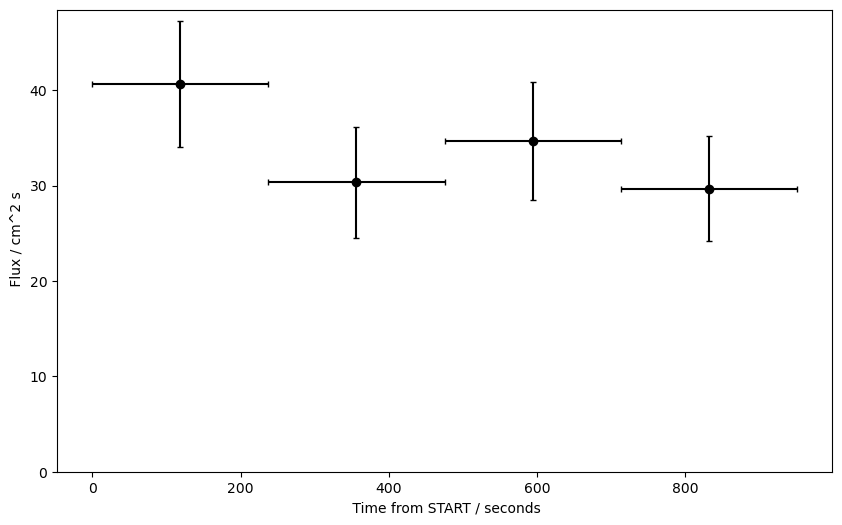

In [143]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=time_center-start_time, y=excess, yerr=err_excess , xerr = delta_t/2 , c='black', capsize=2, fmt='o')

ax.set_ylim( [0, None])
ax.set_xlabel( ' Time from START / seconds')

ax.set_ylabel( ' Flux / cm^2 s')

In [144]:
import scipy.integrate as integrate

In [145]:
max_en = en_high[-1]
total_effective_area = integrate.quad( lambda x: np.interp(x ,  en_center, eff_area), en_th, max_en)[0] * u.m**2 * u.TeV
total_effective_area

/var/folders/cc/9yrg3qln5sq119c30p8bh2h00000gn/T/ipykernel_28366/2487912757.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total_effective_area = integrate.quad( lambda x: np.interp(x ,  en_center, eff_area), en_th, max_en)[0] * u.m**2 * u.TeV


<Quantity 3037686.36902698 m2 TeV>

Text(0, 0.5, ' Flux / cm^2 s')

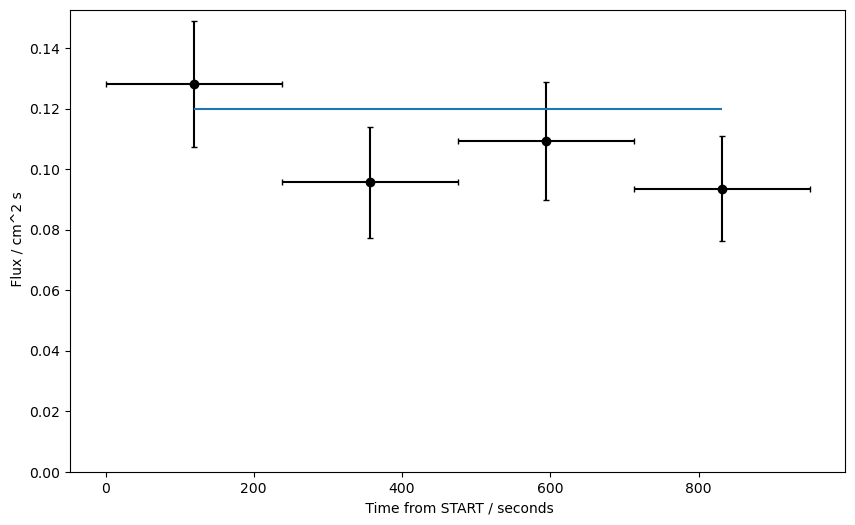

In [146]:
flux = excess/( total_effective_area)/  ( delta_t *u.second) / 1e-9 * ( max_en- en_th) *u.TeV

flux_err = err_excess/( total_effective_area)/  ( delta_t *u.second) / 1e-9 * ( max_en- en_th) *u.TeV




fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=time_center-start_time, 
            y=flux.to( 1/(  u.cm**2 * u.s) ).value, 
            yerr = flux_err.to( 1/( u.cm**2 * u.s) ).value , 
            xerr = delta_t/2 , c='black', capsize=2, fmt='o')

x = np.logspace(-2,1,1000) * u.TeV
f0 = 3.23e-11 * 1/(u.TeV * u.cm**2 * u.s)
E0 = 1 * u.TeV
a  = 2.47
b  = -0.24


ax.hlines( 0.12, np.min(time_center-start_time), np.max(time_center-start_time) )


ax.set_ylim( [0, None])
ax.set_xlabel( ' Time from START / seconds')

ax.set_ylabel( ' Flux / cm^2 s')
#ax.set_xscale('log')
#ax.set_yscale('log')

In [233]:
import gammapy
import gammapy.irf as irf
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation, Observations, DataStore

from gammapy.maps import MapAxis, WcsGeom, Map, RegionGeom
from gammapy.makers import SafeMaskMaker, MapDatasetMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder
from gammapy.estimators import FluxPointsEstimator

import regions
from regions import CircleSkyRegion, PointSkyRegion

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    FoVBackgroundModel,
    SpectralModel,
    #Parameter, 
    TemplateSpectralModel
)
# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets,
    FluxPointsDataset
)

from gammapy.visualization import plot_spectrum_datasets_off_regions

In [473]:
datastore = DataStore.from_dir(f"../1_read_data/data_test/")
obs_ids = [5029747]

#NOT WORKING FOR THE CASE OF THE POINT-LIKE, GETTING AN ERROR WHEN CREATING THE DATASETS. 
observations_crab = datastore.get_observations(obs_ids, required_irf='point-like')

# THIS IS A LIND FROM THE GAMMAPY NOTEBOOKS, THE DATA SEEMS TO BE THE SAME, BUT ALSO NOT WORKING, NO DATA LOADED
observations_crab = datastore.get_observations(
    required_irf=["aeff", "edisp"]
)

In [474]:
from astropy.coordinates import Angle

In [475]:
target_position = SkyCoord(ra=83.63, dec=22.0145, unit="deg", frame="icrs")

theta = observations_crab[0].aeff.meta['RAD_MAX']
assert all(o.aeff.meta['RAD_MAX'] == theta for o in observations_crab)

on_region_radius = Angle(theta*u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

skydir = target_position.galactic

In [476]:
energy_axis = MapAxis.from_energy_bounds(
    0.03204001, 6.185958, nbin=12, per_decade=False, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
   0.01, 10, nbin=12, per_decade=False, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(
    energy_axis_true=energy_axis_true, geom=geom
)


In [479]:
dataset_maker = SpectrumDatasetMaker(
     selection=["counts", "exposure","edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(
                                            min_distance="45 deg",
                                            min_distance_input="5 deg",
                                           max_region_number=3)



In [480]:
%%time
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations_crab):

    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset
                                   , observation)

    datasets.append(dataset_on_off)

CPU times: user 180 ms, sys: 5.35 ms, total: 186 ms
Wall time: 187 ms


In [481]:
gammapy_on         = dataset_on_off.counts.data.flatten()
gammapy_off        = dataset_on_off.counts_off.data.flatten()
gammapy_excess     = dataset_on_off.excess.data.flatten()
gammapy_excess_err = np.sqrt(gammapy_on + gammapy_off*(1/3)**2)

In [482]:
energy_edges= np.array( [ 0.03204001, 0.04967855, 0.07702737, 0.11943215, 0.18518144,
       0.28712675, 0.44519454, 0.69028115, 1.0702919 , 1.6595044 ,
       2.5730877 , 3.989613 , 6.185958]) * u.TeV

In [483]:
spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="crab")

datasets.models = [model]

fit = Fit()
result = fit.run(datasets=datasets)

In [484]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source='crab', selection_optional="all"
)

In [494]:
gammapy_flux = []
gammapy_flux_err = []

for energy_min, energy_max in zip(fpe.energy_edges[:-1], fpe.energy_edges[1:]):
    print(energy_min)
    row = fpe.estimate_flux_point(
        datasets,
        energy_min=energy_min,
        energy_max=energy_max,
    )
    gammapy_flux.append(row['ref_dnde'].value)

0.03204001 TeV
0.04967855 TeV
0.07702737 TeV
0.11943215 TeV
0.18518144 TeV
0.28712675 TeV
0.44519454 TeV
0.69028115 TeV
1.0702919 TeV
1.6595044 TeV
2.5730877 TeV
3.989613 TeV


# COMPARISON GAMMAPY AND ASTROPY

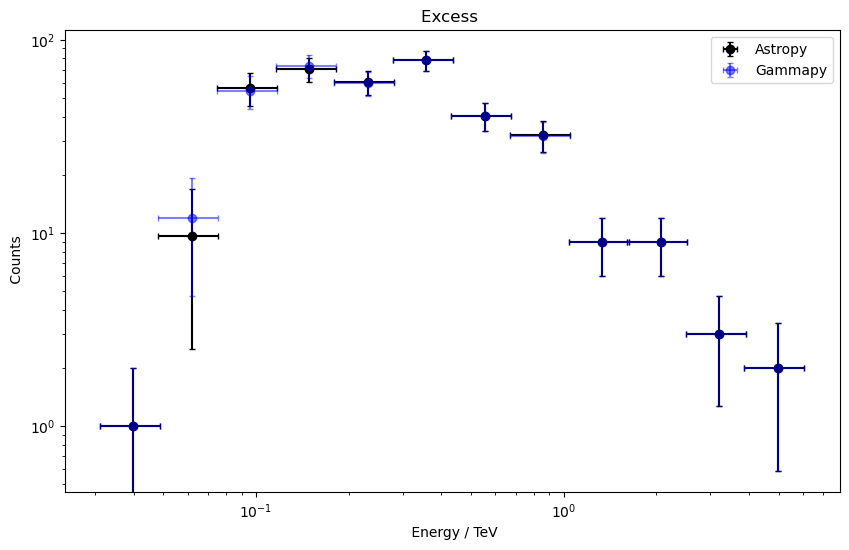

In [351]:

fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.errorbar(x=en_center, y=excess, yerr=err_excess , xerr = delta_E/2 , c='black', capsize=2, fmt='o', label='Astropy')
ax.errorbar(x=en_center, y=gammapy_excess, yerr=gammapy_excess_err , xerr = delta_E/2 , c='blue', capsize=2, fmt='o',alpha=0.5, label='Gammapy')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Counts')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Excess ')
ax.legend();

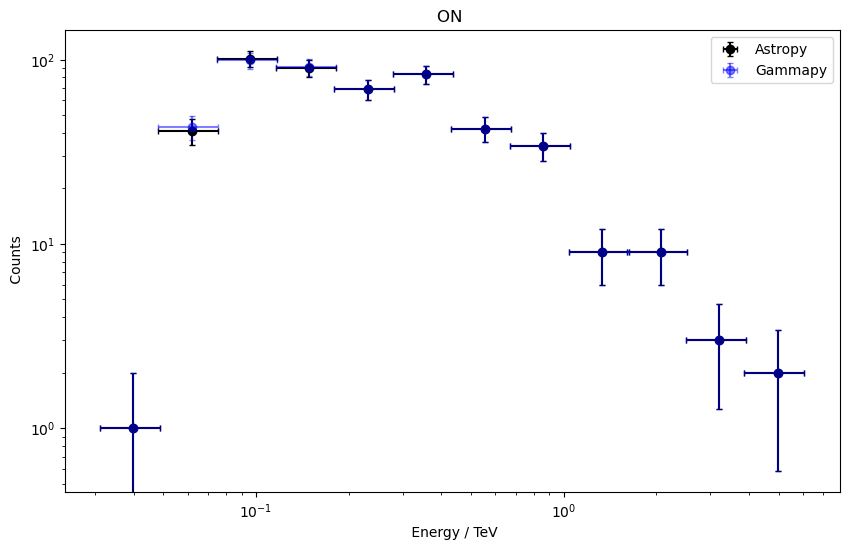

In [352]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.errorbar(x=en_center, y=non_list, yerr=np.sqrt(non_list) , xerr = delta_E/2 , c='black', capsize=2, fmt='o', label='Astropy')
ax.errorbar(x=en_center, y=gammapy_on, yerr=np.sqrt(gammapy_on) , xerr = delta_E/2 , c='blue',  alpha=0.5,capsize=2, fmt='o', label='Gammapy')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Counts')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('ON ')
ax.legend();

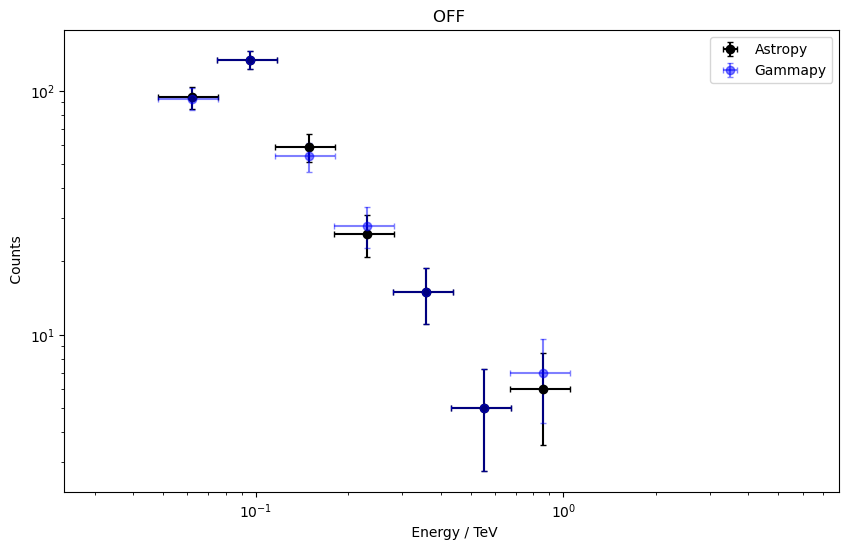

In [353]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.errorbar(x=en_center, y=noff_list, yerr=np.sqrt(noff_list) , xerr = delta_E/2 , c='black', capsize=2, fmt='o', label='Astropy')
ax.errorbar(x=en_center, y=gammapy_off, yerr=np.sqrt(gammapy_off) , xerr = delta_E/2 , c='blue',  alpha=0.5,capsize=2, fmt='o', label='Gammapy')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Counts')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('OFF ')
ax.legend();

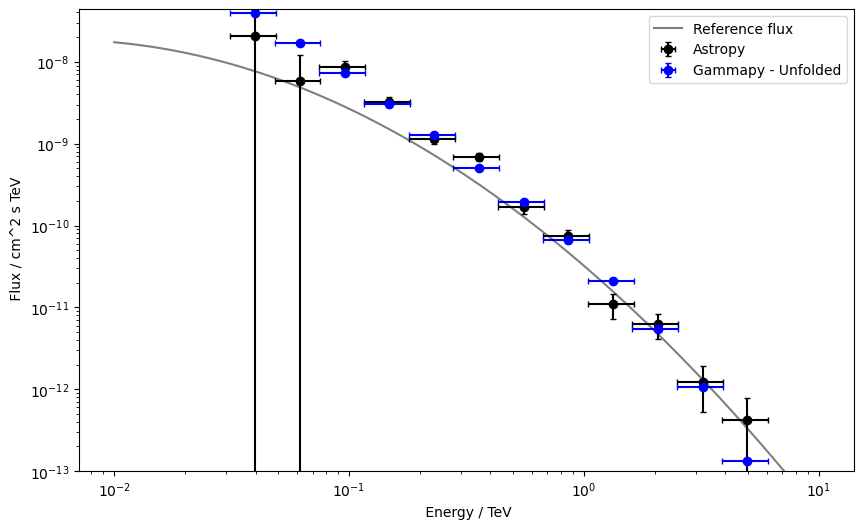

In [501]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, 
            y=flux.to( 1/(u.TeV * u.cm**2 * u.s) ).value, 
            yerr = flux_err.to( 1/(u.TeV * u.cm**2 * u.s) ).value , 
            xerr = delta_E/2 , c='black', capsize=2, fmt='o', label='Astropy')

ax.errorbar(x=en_center, 
            y=gammapy_flux, 
            yerr = 0 , 
            xerr = delta_E/2 , c='blue', capsize=2, fmt='o',label='Gammapy - Unfolded')


x = np.logspace(-2,1,1000) * u.TeV
f0 = 3.23e-11 * 1/(u.TeV * u.cm**2 * u.s)
E0 = 1 * u.TeV
a  = 2.47
b  = -0.24
y = log_parababola(x, f0, E0, a, b)

ax.plot(x,y, c='black', alpha=0.5,label='Reference flux')

ax.set_ylim([1e-13, None])

ax.set_xlabel( ' Energy / TeV')

ax.set_ylabel( ' Flux / cm^2 s TeV')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();